In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
import re
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from tqdm import tqdm
import matplotlib.pyplot as plt


##### Load Data

In [3]:
df = pd.read_excel(r"D:\TA\olx\nama produk final TA.xlsx", sheet_name='skenario 2')
encoder = LabelEncoder()
df['kategori_encoding'] = encoder.fit_transform(df['Kategori'])

In [4]:
kategori = {kategori: index for index, kategori in enumerate(encoder.classes_)}

kategori

{'Elektronik & Gadget > Aksesoris HP & Tablet': 0,
 'Elektronik & Gadget > Elektronik Rumah Tangga': 1,
 'Elektronik & Gadget > Fotografi': 2,
 'Elektronik & Gadget > Games & Console': 3,
 'Elektronik & Gadget > Handphone': 4,
 'Elektronik & Gadget > Komputer': 5,
 'Elektronik & Gadget > Lampu': 6,
 'Elektronik & Gadget > TV & Audio, Video': 7,
 'Elektronik & Gadget > Tablet': 8,
 'Hobi & Olahraga > Alat alat Musik': 9,
 'Hobi & Olahraga > Buku & Majalah': 10,
 'Hobi & Olahraga > Handicrafts': 11,
 'Hobi & Olahraga > Hewan Peliharaan': 12,
 'Hobi & Olahraga > Koleksi & Barang Antik': 13,
 'Hobi & Olahraga > Musik & Film': 14,
 'Hobi & Olahraga > Olahraga': 15,
 'Hobi & Olahraga > Pakaian Olaharaga': 16,
 'Kantor & Industri > Mesin Keperluan Industri': 17,
 'Kantor & Industri > Peralatan Kantor': 18,
 'Kantor & Industri > Perlengkapan Usaha': 19,
 'Kantor & Industri > Stationery': 20,
 'Keperluan Pribadi > Fashion Pria': 21,
 'Keperluan Pribadi > Fashion Wanita': 22,
 'Keperluan Pribadi

In [5]:
print(df.shape)
print(df['Kategori'].value_counts())

(51218, 6)
Kategori
Elektronik & Gadget > Aksesoris HP & Tablet         2973
Properti > Tanah                                    2853
Elektronik & Gadget > Komputer                      2501
Elektronik & Gadget > Handphone                     2301
Hobi & Olahraga > Alat alat Musik                   1981
Elektronik & Gadget > Elektronik Rumah Tangga       1909
Properti > Dijual : Rumah & Apartemen               1847
Properti > Dijual : Bangunan Komersil               1828
Mobil > Mobil Bekas                                 1781
Properti > Disewakan : Rumah & Apartemen            1759
Keperluan Pribadi > Fashion Wanita                  1689
Rumah Tangga > Mebel                                1687
Hobi & Olahraga > Hewan Peliharaan                  1656
Motor > Motor Bekas                                 1655
Elektronik & Gadget > TV & Audio, Video             1485
Keperluan Pribadi > Fashion Pria                    1448
Kantor & Industri > Mesin Keperluan Industri        1155
Rumah Tangg

##### Praproses

In [ ]:
# CASE FOLDING DAN CLEANING 
def preprocess_text(text):
    text = text.lower()  #lowercase
    text = re.sub('[^a-zA-Z ]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['Nama Produk Clean'] = df['Nama Produk'].apply(preprocess_text)

In [ ]:
#  STEMMING
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return stemmer.stem(text)

# memantau progress
tqdm.pandas(desc="Proses Stemming")
df['Nama Produk Stemming'] = df['Nama Produk Clean'].progress_apply(stem_text)


In [ ]:
# daftar stopwords
stop_words = set(stopwords.words('indonesian'))

# untuk menghapus stopwords dari teks
def remove_stopwords(text):
    words = text.split()  #tokenize
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['Nama Produk Final'] = df['Nama Produk Stemming'].apply(remove_stopwords)

In [6]:
# custom words
kata_dihapus  = [
    'ab', 'aal', 'aan', 'aau', 'abab', 'abang', 'abaya', 'abb', 'abc', 'abd', 'abdullah',  'abis', 'abiss', 'acacia', 'aceh', 'ach', 'adacom', 'add', 'adh', 'adi', 'adik',  'adis', 'ado', 'adzan', 'agak', 'agh', 'agm', 'aha', 'aja', 'ajah', 'aji', 'akan', 'akd', 'akj', 'aky', 'alai', 'alamsyah', 'alcott', 'ald', 'all', 'allah',  'almost', 'almuslim', 'aman', 'amanah', 'ambil', 'amed', 'amel', 
    'amin', 'amma', 'ammar', 'amn', 'and', 'anda', 'angels', 'angsu', 'annis', 'ansari', 'ansi', 'antasa', 'anugerah', 'anugrah', 'apalagi', 'apik', 'apk',  'aqa', 'arti', 'asli', 'asy', 'atau', 'att', 'auladi', 'awet', 'ayah', 'baru',
    'ayahanda', 'baba', 'babal', 'babar', 'babarsari', 'bad', 'bae', 'bagas', 'bagus', 'baik', 'bambang', 'bandarlampung', 'banged', 'bangeet', 'banget',  'bangets', 'bangetttt', 'banguntapan', 'bangus', 'banten', 'banyak', 
    'bareng', 'batam', 'bebi', 'bekas', 'beli', 'belum', 'bener', 'berapa', 'bersih', 'besar', 'bestie', 'betul', 'biar', 'biasa', 'bik', 'bikin', 
    'binjai', 'bisa', 'bismillah', 'bismillahirrahmanirrahim', 'bkp', 'blc', 'blkg', 'blkng', 'bontot', 'borong', 'brandnew', 'budi', 'buruk', 'dan', 'canggih', 
    'cantik', 'cell', 'cerdas', 'cicil', 'cod', 'cuma', 'dapat', 'dari', 'dekat', 'dibersihin', 'diskon', 'dpn', 'dulu', 'gampang', 'ganti', 'gembira', 'gratis', 
    'gruduk', 'halim', 'handal', 'hanya', 'hari', 'harum', 'ideal', 'ilmin', 'ingin', 'istimewa', 'izin', 'jangan', 'jawi', 'jelek', 'jemput', 'jual', 'kecil', 'keren', 'kalo', 'kotabaru', 'kreatif', 'krna', 'kuat', 'latin', 'lengkap', 
    'lewat', 'luas', 'mahal', 'makmur', 'mana', 'mandala', 'mansyur', 'mantap', 'mapan', 'masih', 'maupun', 'mdn', 'medang', 'mewah', 'minta', 
    'modern', 'mudah', 'mulus', 'murah', 'nego', 'ngk', 'nyaman', 'ori', 'orisinil', 'orlglnal', 'pahoman', 'palemban', 'palembang', 'palembangstar', 'paling', 'panbil', 'panjang', 'pas', 'pendek', 'petisah', 
    'pinggir', 'plong', 'pragmatic', 'preloved', 'promo', 'puas', 'ramah', 'ramai', 'original', 'ready', 'resmi', 'riau', 'ribet', 'saja', 'salah', 'sampai', 
    'sangat', 'santuy', 'second', 'sederhana', 'segar', 'sejahtera', 'sekarang','selesai', 'sempurna', 'semua', 'senang', 'sepakat', 'siap', 'sidoarjo', 'simpang', 'spesial', 'strategis', 'sudah', 'sukajadi', 'sukses', 'taa', 'tapi', 'tdk', 'tebal', 'telah', 'telukbetung', 'tenang', 'tentram', 'terjangkau', 'tipis', 'tunggu', 'unik', 'unila', 'wahidin', 'wajib', 'yang'
]  

for kata in kata_dihapus:
    df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b' + kata + r'\b', '', regex=True)

# menghapus kata yang terdiri dari satu huruf atau karakter yang berulang
df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b(\w)\1+\b', '', regex=True)  
df['Nama Produk Final'] = df['Nama Produk Final'].str.replace(r'\b\w\b', '', regex=True)  

In [ ]:
# kata yang ingin dicari
kata = 'sewa'

# jumlah kemunculan kata 
jumlah = df['Nama Produk Final'].str.count(r'\b' + kata + r'\b').sum()

print(f"Kata : '{kata}'")
print(f"Jumlah = {jumlah}")


Kata : 'sewa'
Jumlah = 2276


#### **split**


In [7]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df['Nama Produk Final'], df['kategori_encoding'], 
                                                    stratify= df['kategori_encoding'], test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40974,)
Shape of X_test: (10244,)
Shape of y_train: (40974,)
Shape of y_test: (10244,)


In [7]:
original_counts = df['kategori_encoding'].value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

original_proportions = original_counts / original_counts.sum()
train_proportions = train_counts / train_counts.sum()
test_proportions = test_counts / test_counts.sum()

distribution_df = pd.DataFrame({
    'kategori encode': original_counts.index,
    'Jumlah Data Original': original_counts.values,
    'Jumlah Data Latih': train_counts.values,
    'Jumlah Data Uji': test_counts.values,
})
print(distribution_df)

    kategori encode  Jumlah Data Original  Jumlah Data Latih  Jumlah Data Uji
0                 0                  2973               2378              595
1                 1                  1909               1527              382
2                 2                   622                498              124
3                 3                   798                638              160
4                 4                  2301               1841              460
5                 5                  2501               2001              500
6                 6                   452                362               90
7                 7                  1485               1188              297
8                 8                   752                602              150
9                 9                  1981               1585              396
10               10                   254                203               51
11               11                   106                 85    

#### Modelling 


In [8]:
pipeline_1 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(metric='cosine'))
])

param_grid_1 = {
    'knn__n_neighbors': range(1, 21),
    'knn__weights': ['uniform', 'distance'] 
}

In [9]:
kf_1 = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_1 = GridSearchCV(pipeline_1, param_grid_1, cv=kf_1, scoring='accuracy', n_jobs=1,  verbose=2, error_score='raise')
grid_search_1.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  53.2s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time= 1.1min
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time= 1.2min
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  57.4s
[CV] END ...........knn__n_neighbors=1, knn__weights=uniform; total time=  28.6s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  26.1s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  42.6s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  26.8s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  23.6s
[CV] END ..........knn__n_neighbors=1, knn__weights=distance; total time=  28.1s
[CV] END ...........knn__n_neighbors=2, knn__weights=uniform; total time=  29.0s
[CV] END ...........knn__n_neighbors=2, knn__we

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('knn',
                                        KNeighborsClassifier(metric='cosine'))]),
             n_jobs=1,
             param_grid={'knn__n_neighbors': range(1, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [10]:
best_params_1 = grid_search_1.best_params_
print(f"Best parameters: {best_params_1}")

Best parameters: {'knn__n_neighbors': 13, 'knn__weights': 'distance'}


In [11]:
mean_cv_scores = grid_search_1.cv_results_['mean_test_score']
params = grid_search_1.cv_results_['params']
for param, score in zip(params, mean_cv_scores):
    print(f"{param}: {score:.4f}")


{'knn__n_neighbors': 1, 'knn__weights': 'uniform'}: 0.8044
{'knn__n_neighbors': 1, 'knn__weights': 'distance'}: 0.8044
{'knn__n_neighbors': 2, 'knn__weights': 'uniform'}: 0.7963
{'knn__n_neighbors': 2, 'knn__weights': 'distance'}: 0.8042
{'knn__n_neighbors': 3, 'knn__weights': 'uniform'}: 0.7950
{'knn__n_neighbors': 3, 'knn__weights': 'distance'}: 0.8071
{'knn__n_neighbors': 4, 'knn__weights': 'uniform'}: 0.7937
{'knn__n_neighbors': 4, 'knn__weights': 'distance'}: 0.8090
{'knn__n_neighbors': 5, 'knn__weights': 'uniform'}: 0.7926
{'knn__n_neighbors': 5, 'knn__weights': 'distance'}: 0.8095
{'knn__n_neighbors': 6, 'knn__weights': 'uniform'}: 0.7920
{'knn__n_neighbors': 6, 'knn__weights': 'distance'}: 0.8116
{'knn__n_neighbors': 7, 'knn__weights': 'uniform'}: 0.7916
{'knn__n_neighbors': 7, 'knn__weights': 'distance'}: 0.8113
{'knn__n_neighbors': 8, 'knn__weights': 'uniform'}: 0.7905
{'knn__n_neighbors': 8, 'knn__weights': 'distance'}: 0.8125
{'knn__n_neighbors': 9, 'knn__weights': 'uniform

In [13]:
cv_score = grid_search_1.best_score_
test_score = grid_search_1.score(X_test, y_test)

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8125640883975432
Test score: 0.8245802420929325


In [ ]:
print("\nEvaluasi Keseluruhan Data:")
y_test_pred_1 = grid_search_1.predict(X_test)
conf_matrix_test_1 = confusion_matrix(y_test, y_test_pred_1)
class_report_test_1 = classification_report(y_test, y_test_pred_1)
print("Confusion Matrix (Test Data):\n", conf_matrix_test_1)
print("Classification Report (Test Data):\n", class_report_test_1)



Evaluasi Keseluruhan Data:
Confusion Matrix (Test Data):
 [[557   0   2 ...   0   0   0]
 [  2 307   2 ...   1   1   0]
 [  4   3 109 ...   0   0   0]
 ...
 [  0   0   0 ... 192   2   2]
 [  0   4   0 ...   0  59   2]
 [  0   1   0 ...   7   1 257]]
Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       595
           1       0.89      0.80      0.84       382
           2       0.87      0.88      0.87       124
           3       0.92      0.99      0.96       160
           4       0.89      0.94      0.91       460
           5       0.96      0.83      0.89       500
           6       0.72      0.87      0.78        90
           7       0.87      0.81      0.84       297
           8       0.81      0.93      0.87       150
           9       0.95      0.97      0.96       396
          10       0.84      0.94      0.89        51
          11       0.75      0.86      0.80        21
          

In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_pred_1)
print("Akurasi: {:.4f}".format(accuracy))

Akurasi: 0.8246


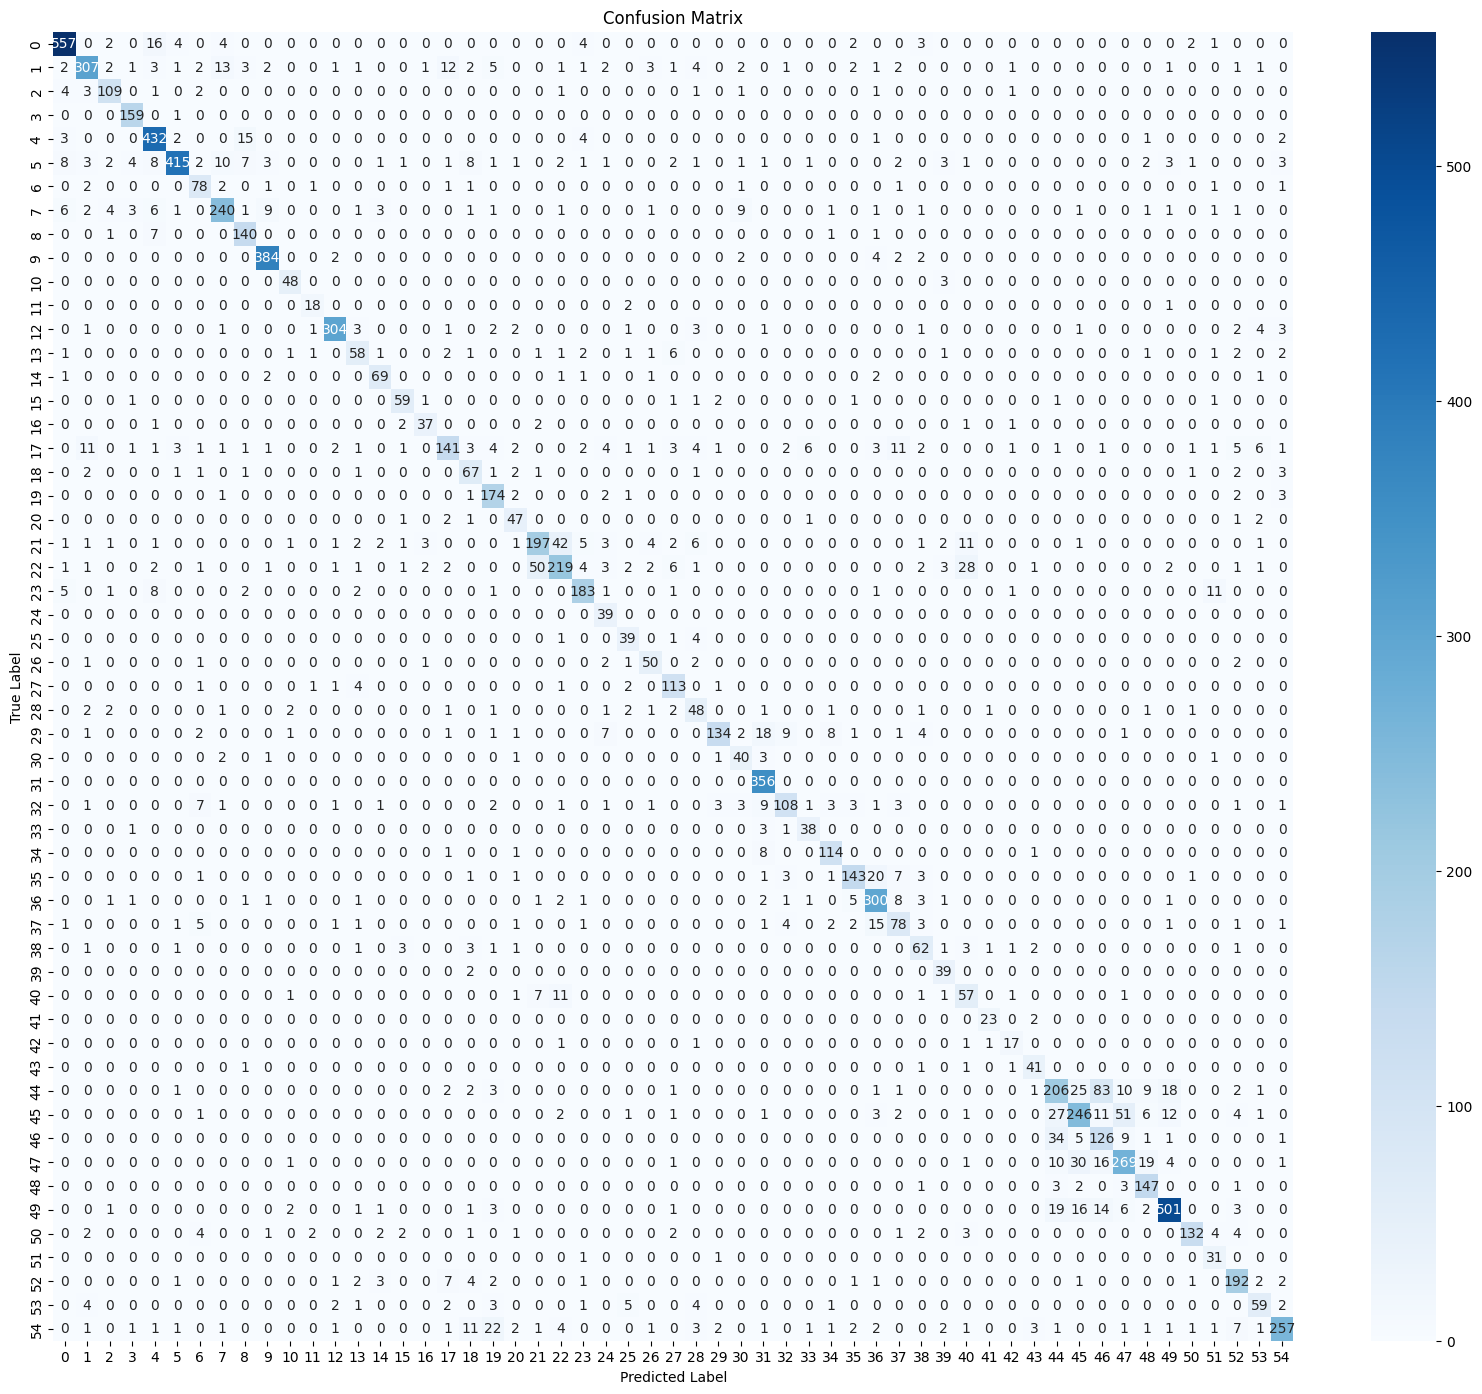

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(20, 17))

sns.heatmap(conf_matrix_test_1, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


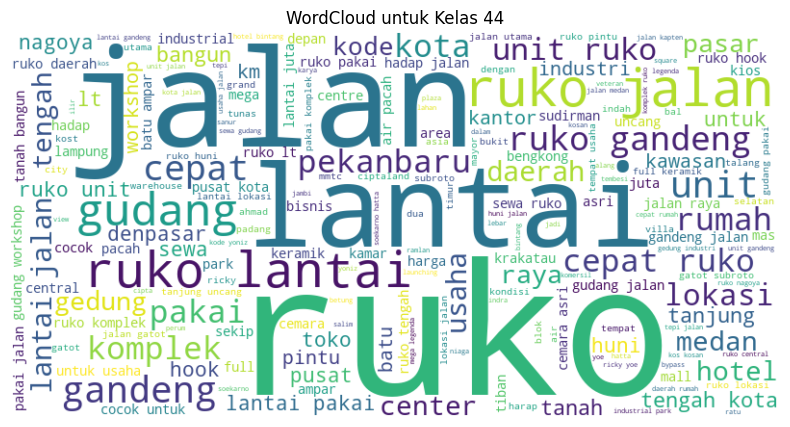

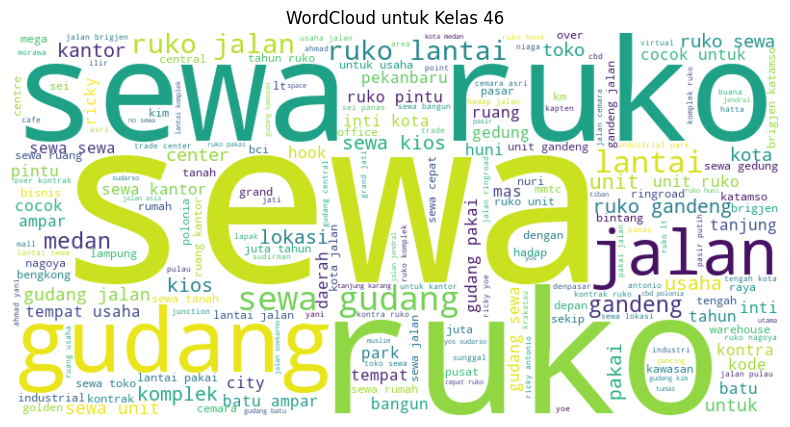

In [53]:

class_44_indices = np.where(y_train == 44)
class_46_indices = np.where(y_train == 46)

# Ambil rata-rata nilai TF-IDF untuk kelas 44 dan 46
class_44_tfidf = np.mean(X_tfidf[class_44_indices].toarray(), axis=0)
class_46_tfidf = np.mean(X_tfidf[class_46_indices].toarray(), axis=0)

# kelas 34
wordcloud_44 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, class_44_tfidf)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_44, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud untuk Kelas 44")
plt.show()

# kelas 46
wordcloud_46 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, class_46_tfidf)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_46, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud untuk Kelas 46")
plt.show()

In [46]:
def prediksi_interaktif(pipeline, encoder):
    while True:
        produk = input("Masukkan nama produk (atau ketik 'exit' untuk keluar): ")
        if produk.lower() == 'exit':
            break
        prediksi = pipeline.predict([produk])
        kategori = encoder.inverse_transform(prediksi)
        print(f"Kategori prediksi untuk '{produk}' adalah: {kategori[0]}")
prediksi_interaktif(grid_search_1, encoder) 

Kategori prediksi untuk 'Piano Yamaha Ysr f51' adalah: Hobi & Olahraga > Alat alat Musik
Kategori prediksi untuk 'Laptop Asus vivobook 15' adalah: Elektronik & Gadget > Komputer
Kategori prediksi untuk 'Apartemen disewakan ' adalah: Properti > Disewakan : Rumah & Apartemen
Kategori prediksi untuk 'Brio RS 2014' adalah: Mobil > Mobil Bekas


### insight ###

In [ ]:
tfidf_filtered = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))

# Mengaplikasikan TF-IDF pada teks yang sudah difilter
tfidf_matrix_filtered = tfidf_filtered.fit_transform(df['Nama Produk Final'])

# Mengonversi ke DataFrame untuk melihat hasilnya
df_df_filtered = pd.DataFrame({
    'Term': tfidf_filtered.get_feature_names_out(),
    'Document Frequency (DF)': (tfidf_matrix_filtered > 0).sum(axis=0).tolist()[0]
})
print(df_df_filtered)

                 Term  Document Frequency (DF)
0               abadi                       12
1       abadi cluster                        1
2        abadi dengan                        1
3         abadi harga                        1
4        abadi lokasi                        1
...               ...                      ...
113158      zyo large                        1
113159     zyo medium                        1
113160          zyrex                        1
113161      zyrex sky                        1
113162            zzn                        1

[113163 rows x 2 columns]


In [ ]:

kategori_mapping = dict(zip(df['kategori_encoding'], df['Kategori']))

original_counts = df['kategori_encoding'].value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

original_proportions = original_counts / original_counts.sum()
train_proportions = train_counts / train_counts.sum()
test_proportions = test_counts / test_counts.sum()

distribution_df = pd.DataFrame({
    'kategori encode': original_counts.index,
    'Kategori Asli': [kategori_mapping[k] for k in original_counts.index],  # Menambahkan kategori asli
    'Jumlah Data Original': original_counts.values,
    'Proporsi Data Original': original_proportions.values,
    'Jumlah Data Latih': train_counts.values,
    'Proporsi Data Latih': train_proportions.values,
    'Jumlah Data Uji': test_counts.values,
    'Proporsi Data Uji': test_proportions.values,
})

distribution_df.loc['Total'] = distribution_df.sum(numeric_only=True)
distribution_df.at['Total', 'kategori encode'] = 'Total'
distribution_df.at['Total', 'Kategori Asli'] = 'Total'
distribution_df.at['Total', 'Proporsi Data Original'] = distribution_df['Proporsi Data Original'].sum()
distribution_df.at['Total', 'Proporsi Data Latih'] = distribution_df['Proporsi Data Latih'].sum()
distribution_df.at['Total', 'Proporsi Data Uji'] = distribution_df['Proporsi Data Uji'].sum()
distribution_df

,kategori encode,Kategori Asli,Jumlah Data Original,Proporsi Data Original,Jumlah Data Latih,Proporsi Data Latih,Jumlah Data Uji,Proporsi Data Uji
0,0.0,Elektronik & Gadget > Aksesoris HP & Tablet,2973.0,0.058046,2378.0,0.058037,595.0,0.058083
1,1.0,Elektronik & Gadget > Elektronik Rumah Tangga,1909.0,0.037272,1527.0,0.037268,382.0,0.037290
2,2.0,Elektronik & Gadget > Fotografi,622.0,0.012144,498.0,0.012154,124.0,0.012105
3,3.0,Elektronik & Gadget > Games & Console,798.0,0.015580,638.0,0.015571,160.0,0.015619
4,4.0,Elektronik & Gadget > Handphone,2301.0,0.044926,1841.0,0.044931,460.0,0.044904
5,5.0,Elektronik & Gadget > Komputer,2501.0,0.048830,2001.0,0.048836,500.0,0.048809
6,6.0,Elektronik & Gadget > Lampu,452.0,0.008825,362.0,0.008835,90.0,0.008786
7,7.0,"Elektronik & Gadget > TV & Audio, Video",1485.0,0.028994,1188.0,0.028994,297.0,0.028993
8,8.0,Elektronik & Gadget > Tablet,752.0,0.014682,602.0,0.014692,150.0,0.014643
9,9.0,Hobi & Olahraga > Alat alat Musik,1981.0,0.038678,1585.0,0.038683,396.0,0.038657


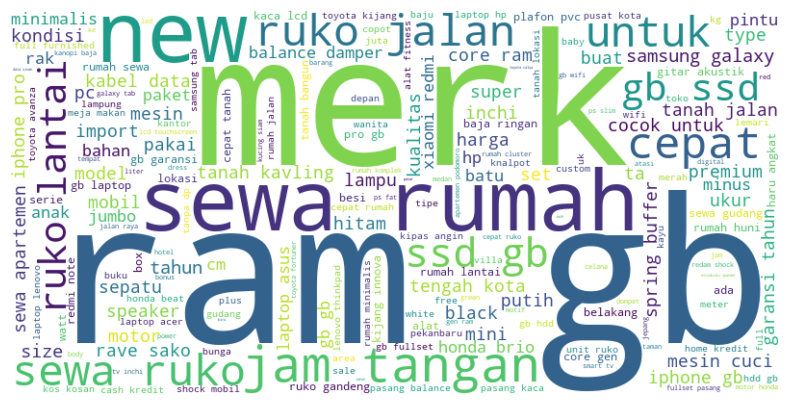

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['Nama Produk Final'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

C:\Users\Naomi Natasya\AppData\Local\Temp\ipykernel_19792\1471416867.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribusi_kategori.values, y=distribusi_kategori.index, palette=palette)


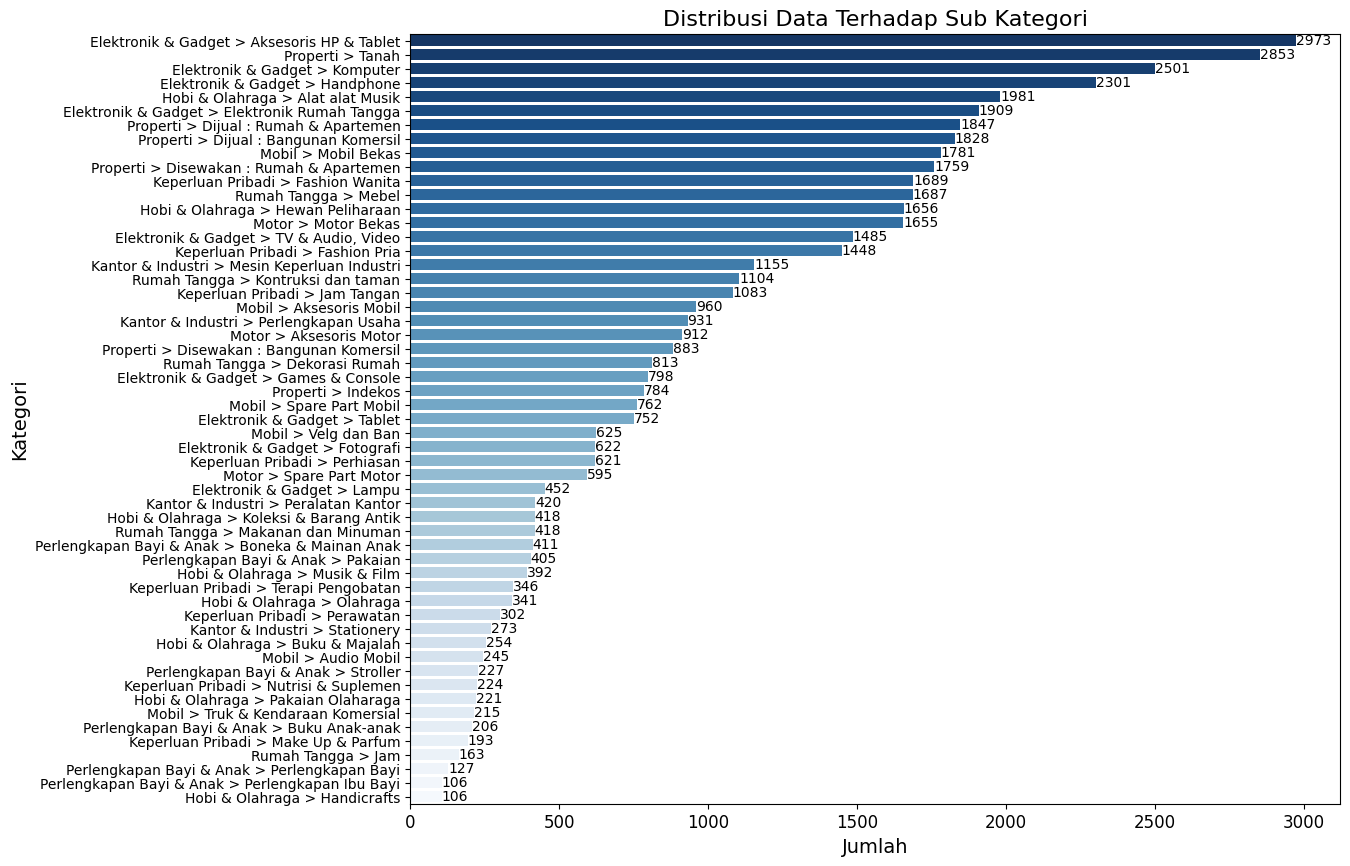

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

distribusi_kategori = df['Kategori'].value_counts()
palette = sns.color_palette("Blues", n_colors=len(distribusi_kategori))
palette.reverse()

plt.figure(figsize=(12, 10))
sns.barplot(x=distribusi_kategori.values, y=distribusi_kategori.index, palette=palette)

plt.title('Distribusi Data Terhadap Sub Kategori', fontsize=16)
plt.xlabel('Jumlah', fontsize=14)
plt.ylabel('Kategori', fontsize=14)

for index, value in enumerate(distribusi_kategori.values):
    plt.text(value, index, f'{value}', va='center', fontsize=10, color='black')

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

plt.show()


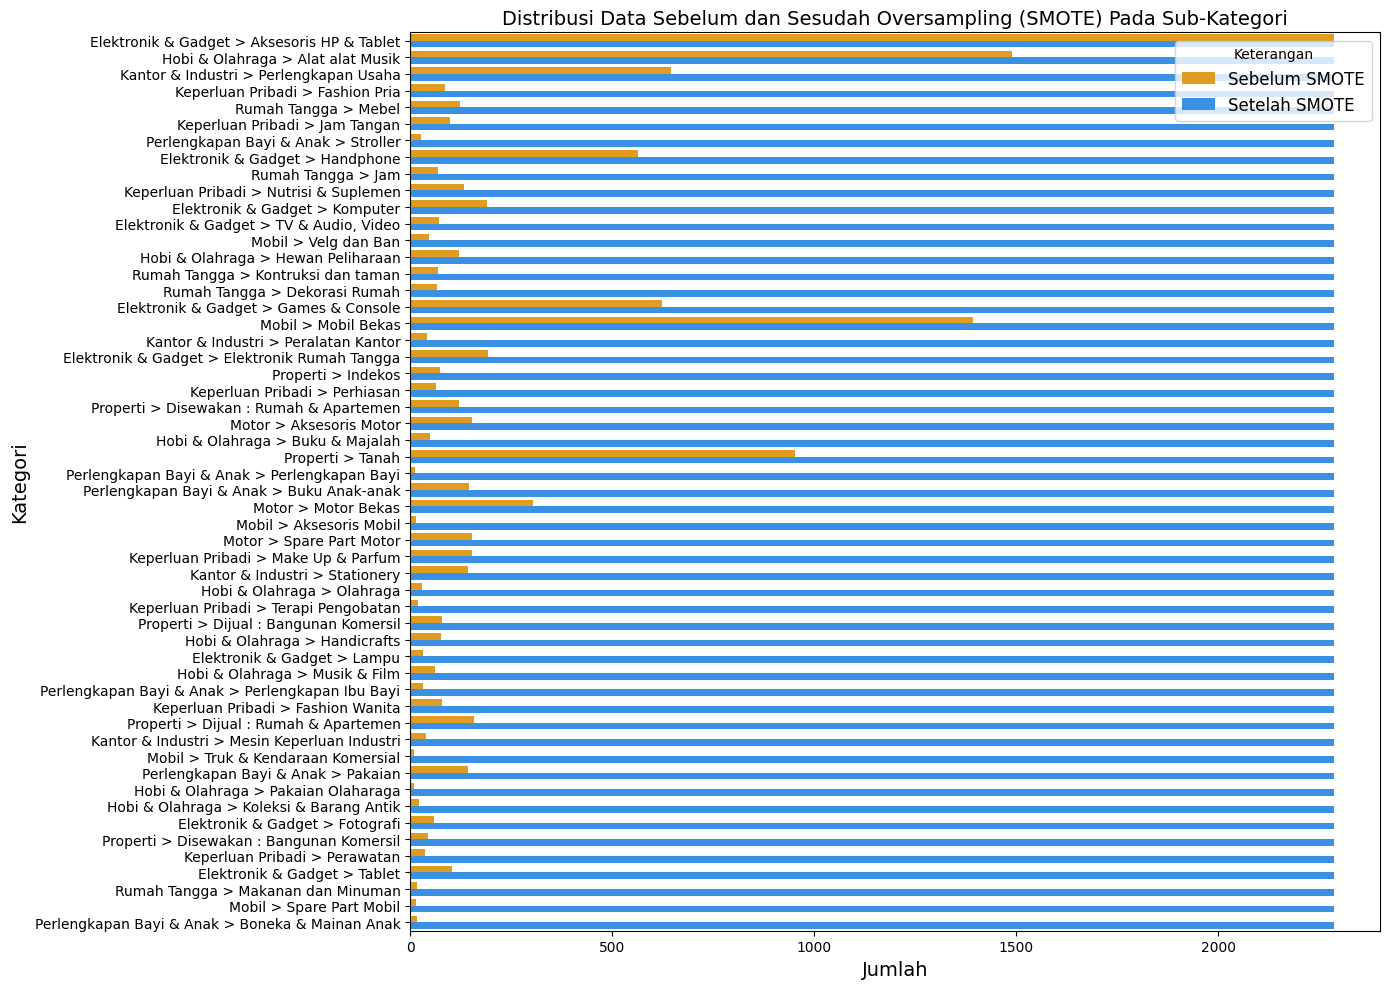

In [ ]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Nama Produk Final'])  # Konversi teks ke numerik dengan TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['kategori_encoding'], test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

kategori_train = encoder.inverse_transform(y_train)
kategori_train_resampled = encoder.inverse_transform(y_train_resampled)

distribusi_sebelum_smote = Counter(kategori_train)

# Distribusi setelah SMOTE
distribusi_setelah_smote = Counter(kategori_train_resampled)

df_distribusi = pd.DataFrame({
    'Kategori': list(distribusi_sebelum_smote.keys()),
    'Sebelum SMOTE': list(distribusi_sebelum_smote.values()),
    'Setelah SMOTE': [distribusi_setelah_smote.get(kategori, 0) for kategori in distribusi_sebelum_smote.keys()]
})

df_distribusi_melted = df_distribusi.melt(id_vars="Kategori", var_name="Jenis", value_name="Jumlah")

# Visualisasi distribusi sebelum dan setelah SMOTE
# Visualisasi distribusi sebelum dan setelah SMOTE dengan warna orange dan blue
plt.figure(figsize=(14, 10))

custom_palette = ["#FFA500", "#1E90FF"]  # Oranye (FFA500) dan Biru (1E90FF)

sns.barplot(x="Jumlah", y="Kategori", hue="Jenis", data=df_distribusi_melted, palette=custom_palette)
plt.title('Distribusi Data Sebelum dan Sesudah Oversampling (SMOTE) Pada Sub-Kategori', fontsize=14)
plt.xlabel('Jumlah', fontsize=14)
plt.ylabel('Kategori', fontsize=14)
plt.legend(title='Keterangan', fontsize=12)
plt.tight_layout()
plt.show()